In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels
import statsmodels.sandbox.stats.multicomp
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [35]:
data = pd.read_csv("ab_browser_test.csv")
data.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [4]:
data[data['slot']== 'control'].describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,284554.000000,284554.000000,284554.000000,284554.000000
mean,301466.225068,11.280906,10.847909,4.883502
std,175551.820225,20.282018,16.564624,8.386714
min,6.000000,0.000000,1.000000,0.000000
25%,148725.250000,1.000000,2.000000,1.000000
50%,299620.500000,4.000000,5.000000,2.000000
75%,455704.500000,13.000000,13.000000,6.000000
max,603136.000000,863.000000,435.000000,386.000000


In [5]:
exp_ = float(data[data['slot']== 'exp'].n_clicks.sum()) 
control = float(data[data['slot']== 'control'].n_clicks.sum())

In [6]:
print ((exp_ - control) / control) * 100
print exp_
print control

1.61356898244
3261823.0
3210027.0


In [7]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

np.array(data[data.slot == 'exp'].n_clicks.values, dtype=float)

array([ 23.,   3.,  29., ...,   4.,   4.,   3.])

In [8]:
exp_ = np.array(data[data.slot == 'exp'].n_clicks.values, dtype=float)
control = np.array(data[data.slot == 'control'].n_clicks.values, dtype=float)

#np.random.seed(0)

exp_median_scores = map(np.median, get_bootstrap_samples(exp_, 1000))
control_median_scores = map(np.median, get_bootstrap_samples(control, 1000))

print "95% click median:",  stat_intervals(exp_median_scores, 0.05)
print "95% non click median:",  stat_intervals(control_median_scores, 0.05)

delta_median_scores = map(lambda x: x[1] - x[0], zip(exp_median_scores, control_median_scores))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

exp_mean_scores = map(np.mean, get_bootstrap_samples(exp_, 1000))
control_mean_scores = map(np.mean, get_bootstrap_samples(control, 1000))

print "95% click medmeanian:",  stat_intervals(exp_mean_scores, 0.05)
print "95% non click mean:",  stat_intervals(control_mean_scores, 0.05)

delta_mean_scores = map(lambda x: x[1] - x[0], zip(exp_mean_scores, control_mean_scores))

print "95% confidence interval for the difference between mean",  stat_intervals(delta_mean_scores, 0.05)

95% click median: [ 5.  5.]
95% non click median: [ 4.  4.]
95% confidence interval for the difference between medians [-1. -1.]
95% click medmeanian: [ 11.5141506   11.66101508]
95% non click mean: [ 11.20842116  11.3545834 ]
95% confidence interval for the difference between mean [-0.40855723 -0.20051129]


C:\Users\nlavr\Anaconda2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


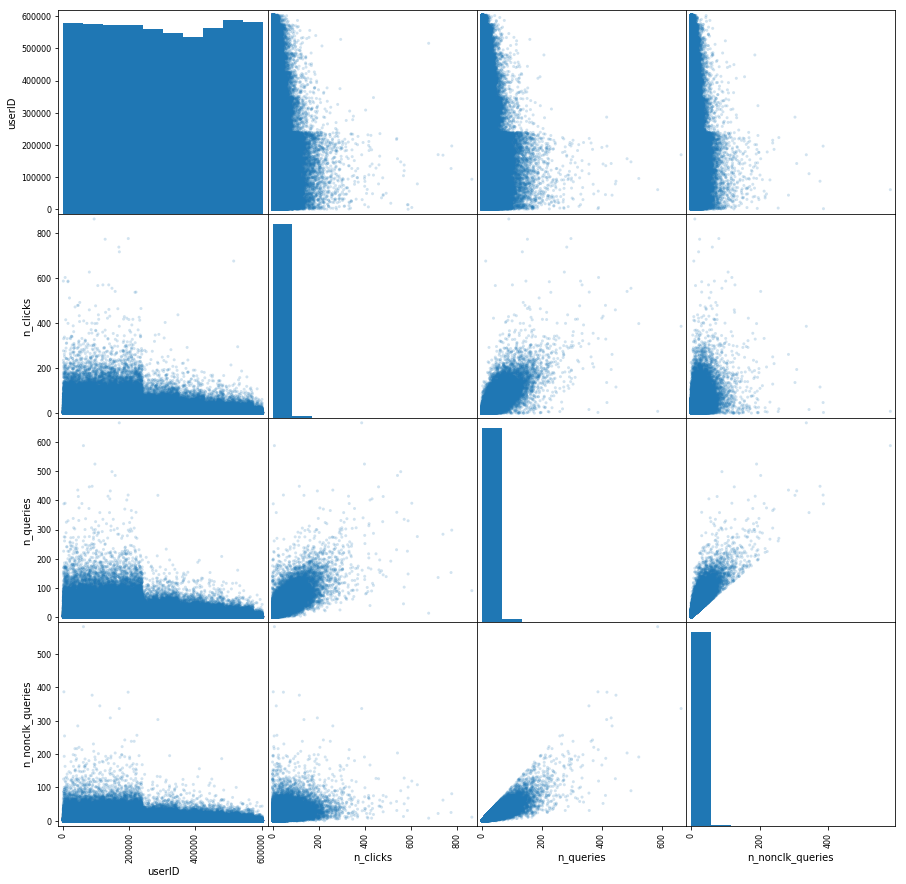

In [9]:
pd.tools.plotting.scatter_matrix(data, alpha=0.2, 
                                 figsize=(15, 15), diagonal='hist')
pylab.show()

In [10]:
ctrl = np.array(data[data.slot == 'control'].n_clicks.values, dtype=float)

np.random.seed(0)
samples = get_bootstrap_samples(ctrl, 500)
c_mean_scores = map(np.mean, samples)
c_var = []
i = 0
for s in samples:
    m = np.mean(s)
    c_var.append(sum(map(lambda x: (m - x) ** 2, s)))


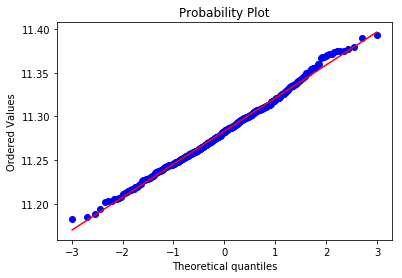

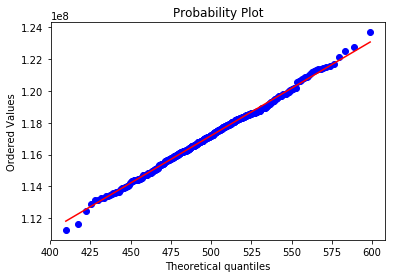

In [11]:
r1 = scipy.stats.probplot(c_mean_scores, dist = "norm", plot = plt)
#print r1
pylab.show()

r2 = scipy.stats.probplot(c_var, dist="chi2", sparams=(len(c_var)-1), plot=plt)
#print r2
pylab.show()

In [34]:

#exp_ = np.array(data[data.slot == 'exp'].n_clicks.values, dtype=float)
#control = np.array(data[data.slot == 'control'].n_clicks.values, dtype=float)
#print data[data.slot == 'exp']
exp_c = data[data.slot == 'exp'].groupby(['userID'])['n_clicks'].sum().values
ctrl_c = data[data.slot == 'control'].groupby(['userID'])['n_clicks'].sum().values

scipy.stats.mannwhitneyu(exp_c, ctrl_c)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [56]:
exp_br = data[data.slot == 'exp'].groupby(['browser'])['n_clicks']
ctrl_br = data[data.slot == 'control'].groupby(['browser'])['n_clicks']

arr = {}
for k, v in exp_br:
    arr[k] = v.values
    print k
mv = []
for k, v in ctrl_br:
    mv.append(scipy.stats.mannwhitneyu(arr[k], v.values).pvalue)
print mv

reject, p_corrected, a1, a2 =  statsmodels.sandbox.stats.multicomp.multipletests(mv, 
                                            alpha = 0.05 / 6, 
                                            method = 'holm') 
print p_corrected
print 0.05 / 6


Browser #14
Browser #17
Browser #2
Browser #20
Browser #22
Browser #4
[0.0, 0.037400601430108017, 0.027243860419724101, 0.45366656388735377, 0.25740551522100319, 0.40760617658454984]
[ 0.          0.14960241  0.1362193   0.81521235  0.77221655  0.81521235]
0.00833333333333


In [65]:
exp_br = data[data.slot == 'exp'].groupby(['browser'])
ctrl_br = data[data.slot == 'control'].groupby(['browser'])

arr = {}
for k, v in exp_br:
    print k, 100 * float(v['n_nonclk_queries'].sum()) / v['n_queries'].sum()
print '--'
for k, v in ctrl_br:
    print k, 100 * float(v['n_nonclk_queries'].sum()) / v['n_queries'].sum()


Browser #14 43.7556173613
Browser #17 36.9374128487
Browser #2 44.9827469486
Browser #20 38.9773764837
Browser #22 39.8539472197
Browser #4 45.1429419036
--
Browser #14 57.5904113601
Browser #17 36.2993667463
Browser #2 45.9627471792
Browser #20 40.5404847434
Browser #22 40.5939765935
Browser #4 46.9709296351
